# Optmization of the penalty function using Lagrange multiplier

- toc: true
- badges: true
- comments: true
- categories: [trend-filtering, mr-ash, regression-methods, mr-ash-pen]
- slug: mrash-penalized-penalty-optimization-lagrange-multiplier

## About

An interesting sub-problem for the penalized regression formulation of the Mr.ASH sparse multiple linear regression involves optimization of the penalty function $\rho$.
The details of the theory are written in [Overleaf](https://www.overleaf.com/project/60d0d9301e098e4dbe8e3521).
The numerical optimization of $\rho$ can be performed using:
 - method of Lagrangian multipliers
 - partial updates with ADMM


Here, we show a basic implementation of the method of Lagrangian multipliers.

In [1]:
#collapse-hide

import numpy as np
from scipy import optimize as sp_optimize

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if gc > 0: x[i] = np.random.normal(0, sk[gc])
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

We generate 500 samples from a normal means distribution whose mean is obtained from Mr.ASH prior and a given variance ( $= \sigma^2 v_j^2$). In a multiple regression setting,

$\mathbf{y} \mid \mathbf{X}, \mathbf{b}, \sigma  \sim \mathcal{N}(\mathbf{y} \mid \mathbf{X}\mathbf{b}, \sigma^2\mathbb{I}$),

the NM samples are equivalent to the regression coefficients $\mathbf{b}$.
Given $\sigma_k$ (the standard deviation of the mixture components in the Mr.ASH prior), 
$\sigma$ and $v_j^2 = (\mathbf{X}^{\mathsf{T}}\mathbf{X})^{-1}$,
the target is to recover the mixture weights $w_k$ of the Mr.ASH prior
and the corresponding $\theta$ such that $M_{w, \sigma}(\boldsymbol{\theta}) = b$,
where $M_{w, \sigma}$ is the NM Posterior Means Operator.

We consider the minimization of the penalty function,

$\min_{w, \theta} \sum_{j=1}^{P} \frac{1}{\sigma^2 v_j^2} \rho_{w, \sigma} (M_{w, \sigma}(\theta_j))$
subject to
$w_k \ge 0, \sum_{k} w_k = 1$ and $M_{w, \sigma}(\theta_j) = b_j$

Note: Ideally, $\sigma$ also needs to be obtained from the optimization but is assumed to be known for now. In this document, I have not yet implemented the derivatives of the objective function although it can be done as derived in the Overleaf notebook.

In [2]:
#collapse-show

p = 500
k = 3
sparsity = 0.9
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
dj = np.ones(p)

We use a softmax parametrization of $w_k$ to enforce the constraints on $w_k$ and use the method of Lagrange multipliers for the third constraint $M_{w, \sigma}(\theta_j) = b_j$.

In [3]:
#collapse-hide

def softmax(x, base = np.exp(1)):
    if base is not None:
        beta = np.log(base)
        x = x * beta
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis = 0, keepdims = True)

def penalty_operator(z, wk, std, sk, dj):
    nm = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    tvar = (std * std) / dj
    lambdaj = - nm.logML - 0.5 * tvar * np.square(nm.logML_deriv)
    return lambdaj

def shrinkage_operator(nm):
    M        = nm.y + nm.yvar * nm.logML_deriv
    M_bgrad  = 1       + nm.yvar * nm.logML_deriv2
    M_wgrad  = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
    M_s2grad = (nm.logML_deriv / nm._d) + (nm.yvar * nm.logML_deriv_s2deriv)
    return M, M_bgrad, M_wgrad, M_s2grad

def unshrink_b(b, std, wk, sk, dj, theta = None, max_iter = 100, tol = 1e-8):
    # this is the initial value of theta
    if theta is None:
        theta = np.zeros_like(b)
    # Newton-Raphson iteration
    for itr in range(max_iter):
        nmash = NormalMeansASHScaled(theta, std, wk, sk, d = dj)
        Mtheta, Mtheta_bgrad, _, _ = shrinkage_operator(nmash)
        theta_new = theta - (Mtheta - b) / Mtheta_bgrad
        diff = np.sum(np.square(theta_new - theta))
        theta = theta_new
        obj = np.sum(- nmash.logML - 0.5 * nmash.yvar * np.square(nmash.logML_deriv))
        print(obj)
        if diff <= tol:
            break
    return theta

def shrink_theta(z, std, wk, sk, dj):
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    Mb = shrinkage_operator(nmash)[0]
    return Mb

def penalty_operator_lagrangian(z, wk, std, sk, dj, lgrng, b):
    Mt  = shrink_theta(z, std, wk, sk, dj)
    hwt = penalty_operator(z, wk, std, sk, dj)
    obj = np.sum(hwt) + np.sum(lgrng * (Mt - b))
    return obj

def penalty_operator_lagrangian_deriv(z, wk, std, sk, dj, lgrng, b):
    '''
    The Normal Means model
    '''
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    '''
    gradient w.r.t lambda_j (lagrangian penalty)
    '''
    M, M_bgrad, M_wgrad, M_s2grad  = shrinkage_operator(nmash)
    dLdl = M - b
    '''
    gradient w.r.t wk (prior mixture coefficients)
    '''
    tvar  = (strue * strue) / dj
    v2_ld_ldwd = tvar.reshape(-1, 1) * nmash.logML_deriv.reshape(-1, 1) * nmash.logML_deriv_wderiv
    ## gradient of first term and second term of the lagrangian
    l1_wgrad = - nmash.logML_wderiv - v2_ld_ldwd
    l2_wgrad = lgrng.reshape(-1, 1) * M_wgrad
    dLdw = np.sum(l1_wgrad + l2_wgrad, axis = 0)
    '''
    gradient w.r.t theta
    '''
    l1_tgrad = - nmash.logML_deriv  - tvar * nmash.logML_deriv * nmash.logML_deriv2
    l2_tgrad = lgrng * (1 + tvar * nmash.logML_deriv2)
    dLdt = l1_tgrad + l2_tgrad
    return dLdl, dLdw, dLdt

def objective_numeric_lagrangian(params, std, sk, dj, b, p, k, softmax_base):
    zj = params[:p]
    lj = params[p:2*p]
    ak = params[2*p:]
    wk = softmax(ak, base = softmax_base)
    dLdl, dLdw, dLdt = penalty_operator_lagrangian_deriv(zj, wk, strue, sk, dj, lj, btrue)
    akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    dLda = np.sum(dLdw * akjac, axis = 1)
    obj = np.sqrt(np.sum(np.square(dLdl)) + np.sum(np.square(dLda)) + np.sum(np.square(dLdt)))
    return obj

We initialize $\boldsymbol{\theta}$ from a random distribution, initialize $w_k = 1 / K$ for all $k$ and initialize the Lagrange multipliers $\lambda_j = 2$ for all $j$.

In [4]:
#collapse-show

z = np.random.rand(p)
softmax_base = np.exp(1)
winit, _ = initialize_ash_prior(k)
akinit = np.log(winit + 1e-8) / np.log(softmax_base)
lgrng = np.ones(btrue.shape[0]) * 2.0
wk  = softmax(akinit, base = softmax_base)

The optimization is carried out using Scipy default optimization routine with conjugate gradient descent and numerical derivatives.

In [5]:
# collapse-show

initparams = np.concatenate([z, lgrng, akinit])
cg_min = sp_optimize.minimize(objective_numeric_lagrangian, initparams,
                              args = (strue, sk, dj, btrue, p, k, softmax_base),
                              method = 'CG',
                              options = {'disp': True, 'maxiter': 50, 'return_all': True}
                             )

         Current function value: 0.183546
         Iterations: 50
         Function evaluations: 133532
         Gradient evaluations: 133


We compare the true mixture coefficients $w_k$ with the estimates $\hat{w}_k$. We estimate the coefficients $\hat{b}_j = M_{\hat{w}, \sigma}(\hat{\theta}_j)$ from the estimates of $\hat{\theta}_j$.

In [6]:
# collapse-hide

z_cg = cg_min.x[:p]
a_cg = cg_min.x[2*p:]
w_cg = softmax(a_cg, base = softmax_base)
lj_cg = cg_min.x[p:2*p]
print ("True w:", wtrue)
print("Est. w: ", w_cg)
print("Est. Lagrangian (for non-zero b): ")
print(lj_cg[btrue!=0])

True w: [0.9  0.05 0.05]
Est. w:  [8.40644315e-10 9.99999999e-01 2.08126716e-17]
Est. Lagrangian (for non-zero b): 
[ 10.13074213  -0.64488124   4.80793829 -17.76524182  -0.41550097
   3.95569524  -4.9611557    8.86351506  12.63715305  -2.69973203
  15.98012982  -0.56311216   1.53066453  -4.28852133   3.73659887
  -6.0898489    1.32604332   0.36453834   2.84274398   1.17521531
  -0.72211153  -1.52709717  16.88752323  -2.84192143   1.98402504
   9.89335874   1.69546814   7.15441456  -0.15848208   0.67881027
   8.9399216   -1.83993999   3.23553295  -1.49794461   8.51721126
  -0.5536934    4.85207513   1.51627217  -5.42310313   3.0111238
  -1.26810787  -3.74695945 -12.61411982   3.78208547  -4.11100894
   7.75132838   9.96315544 -11.38539447   5.88183688  -1.98197591
  -8.54268782  -5.90422699]


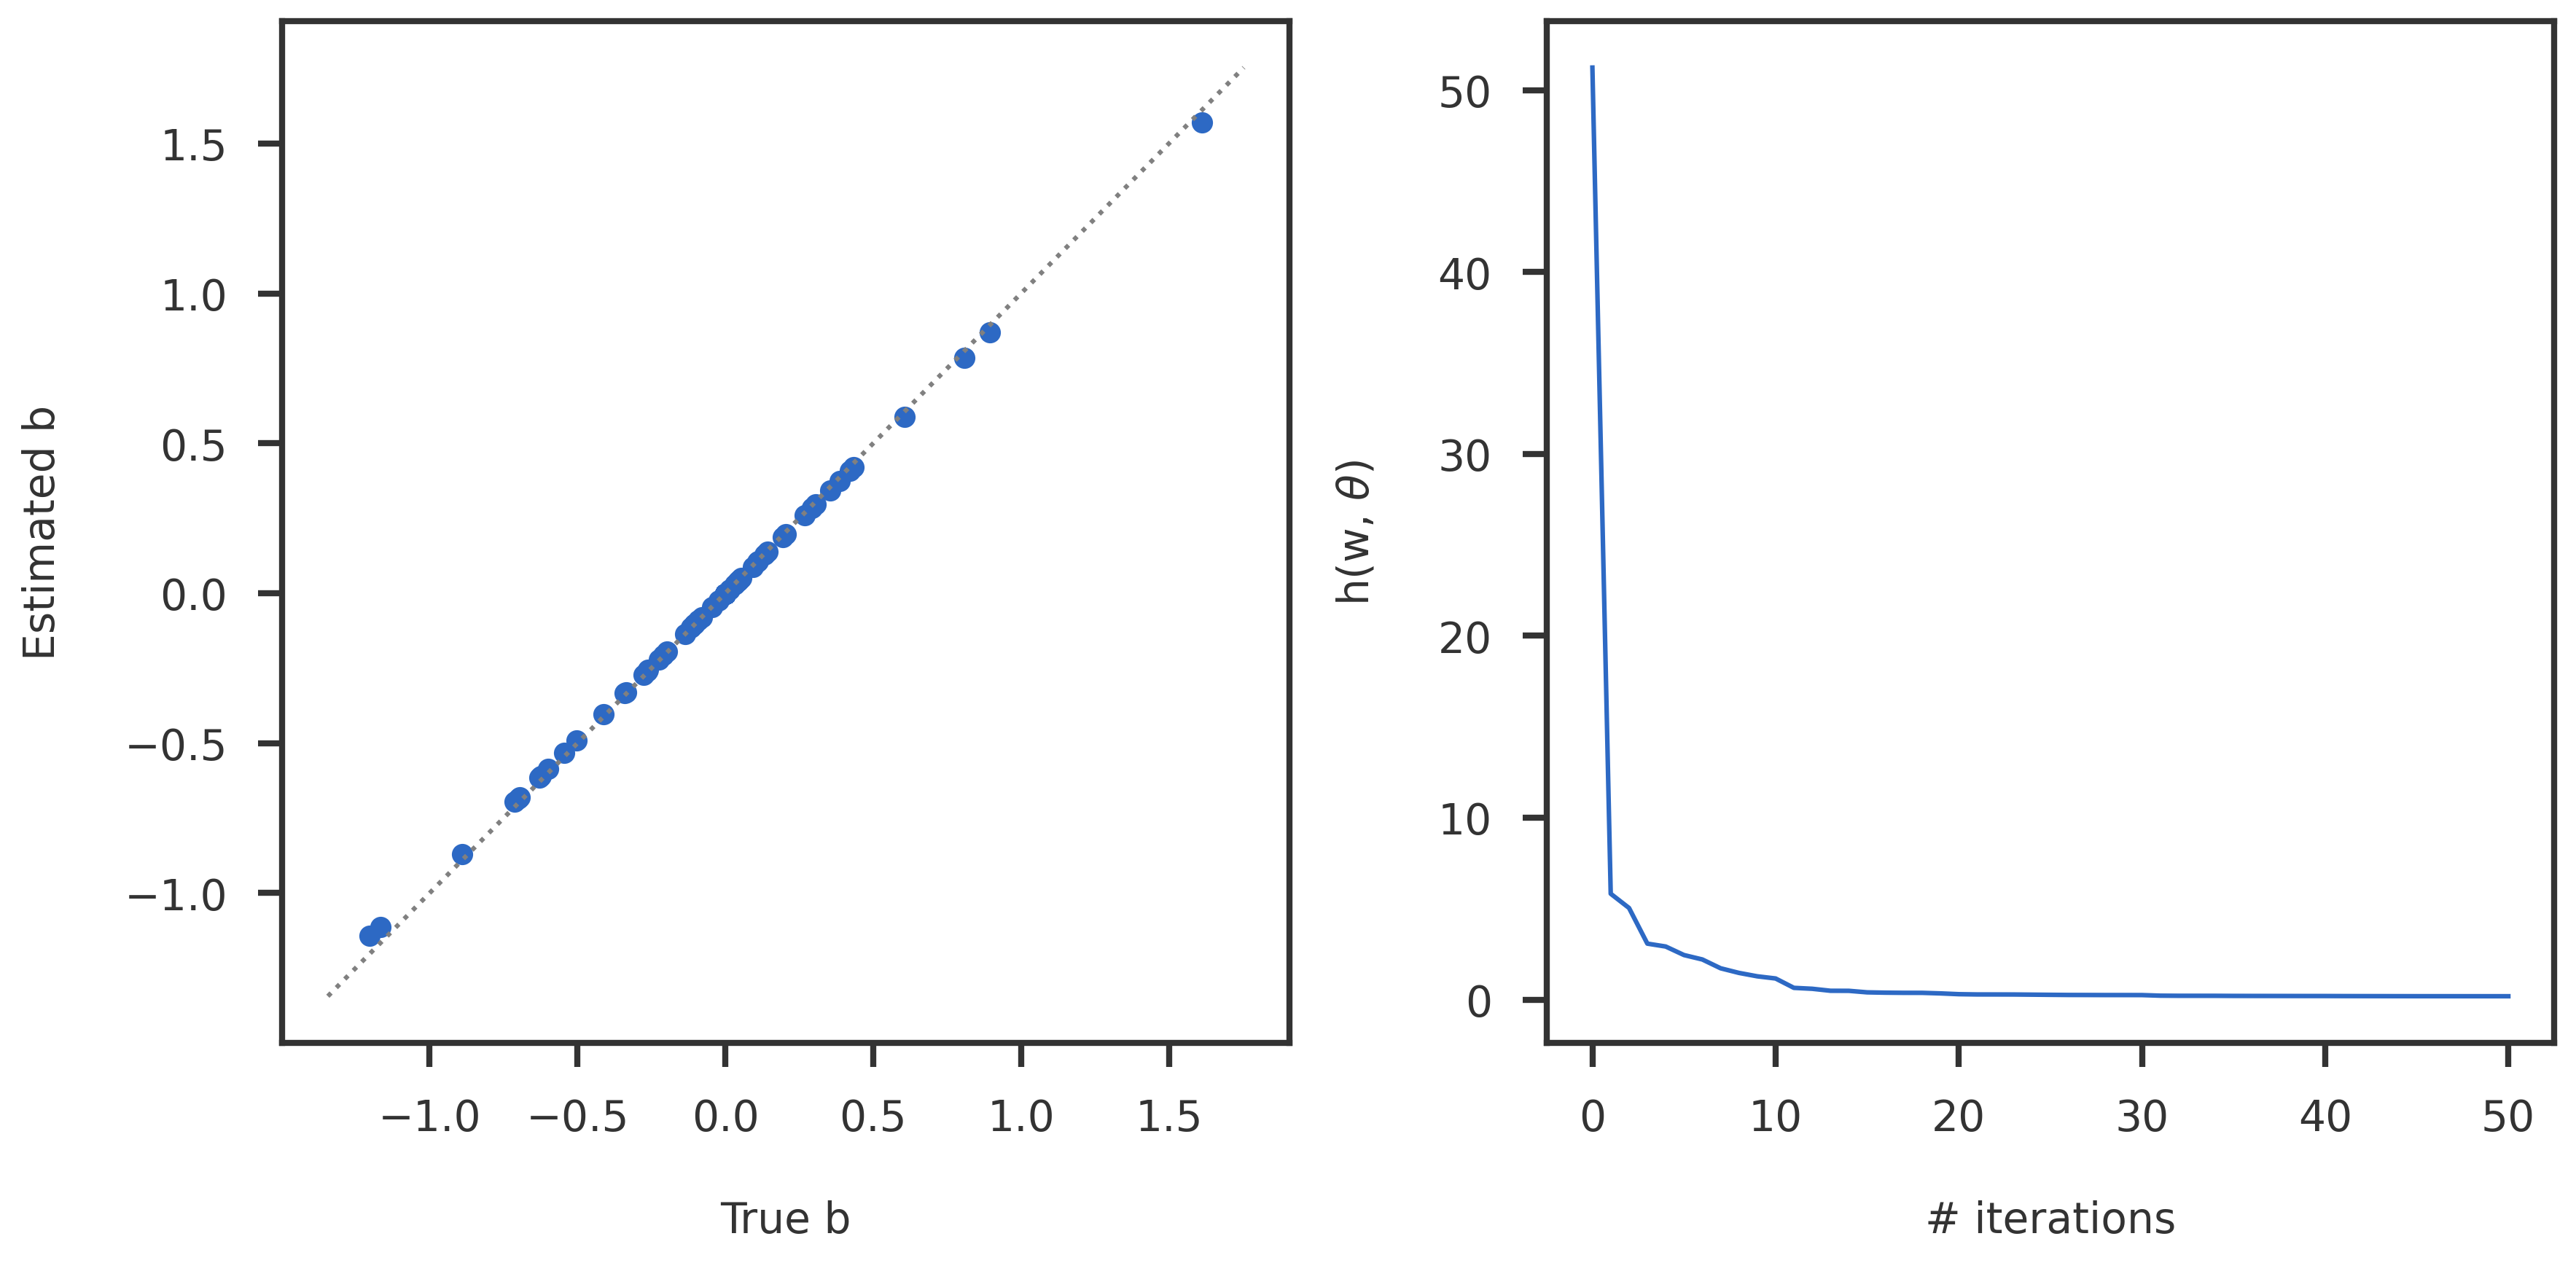

In [7]:
#collapse-hide

b_cg = shrink_theta(z_cg, strue, w_cg, sk, dj)
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(btrue, b_cg)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("True b")
ax1.set_ylabel("Estimated b")

niter   = cg_min.nit
allobjs = np.zeros(niter + 1)
for i, params in enumerate(cg_min.allvecs):
    z_it = params[:p]
    a_it = params[2*p:]
    lj_it = params[p:2*p]
    w_it = softmax(a_it, base = softmax_base)
    #alllagrangian[i] = penalty_operator_lagrangian(z_it, w_it, strue, sk, dj, lj_it, btrue)
    allobjs[i] = objective_numeric_lagrangian(params, strue, sk, dj, btrue, p, k, softmax_base)
ax2.plot(np.arange(niter + 1), allobjs)
ax2.set_xlabel("# iterations")
ax2.set_ylabel(r"h(w, $\theta$)")

plt.tight_layout()

plt.show()

Here, I show the evolution of $w_k$ and estimated $\mathbf{b}$ over the iterations.

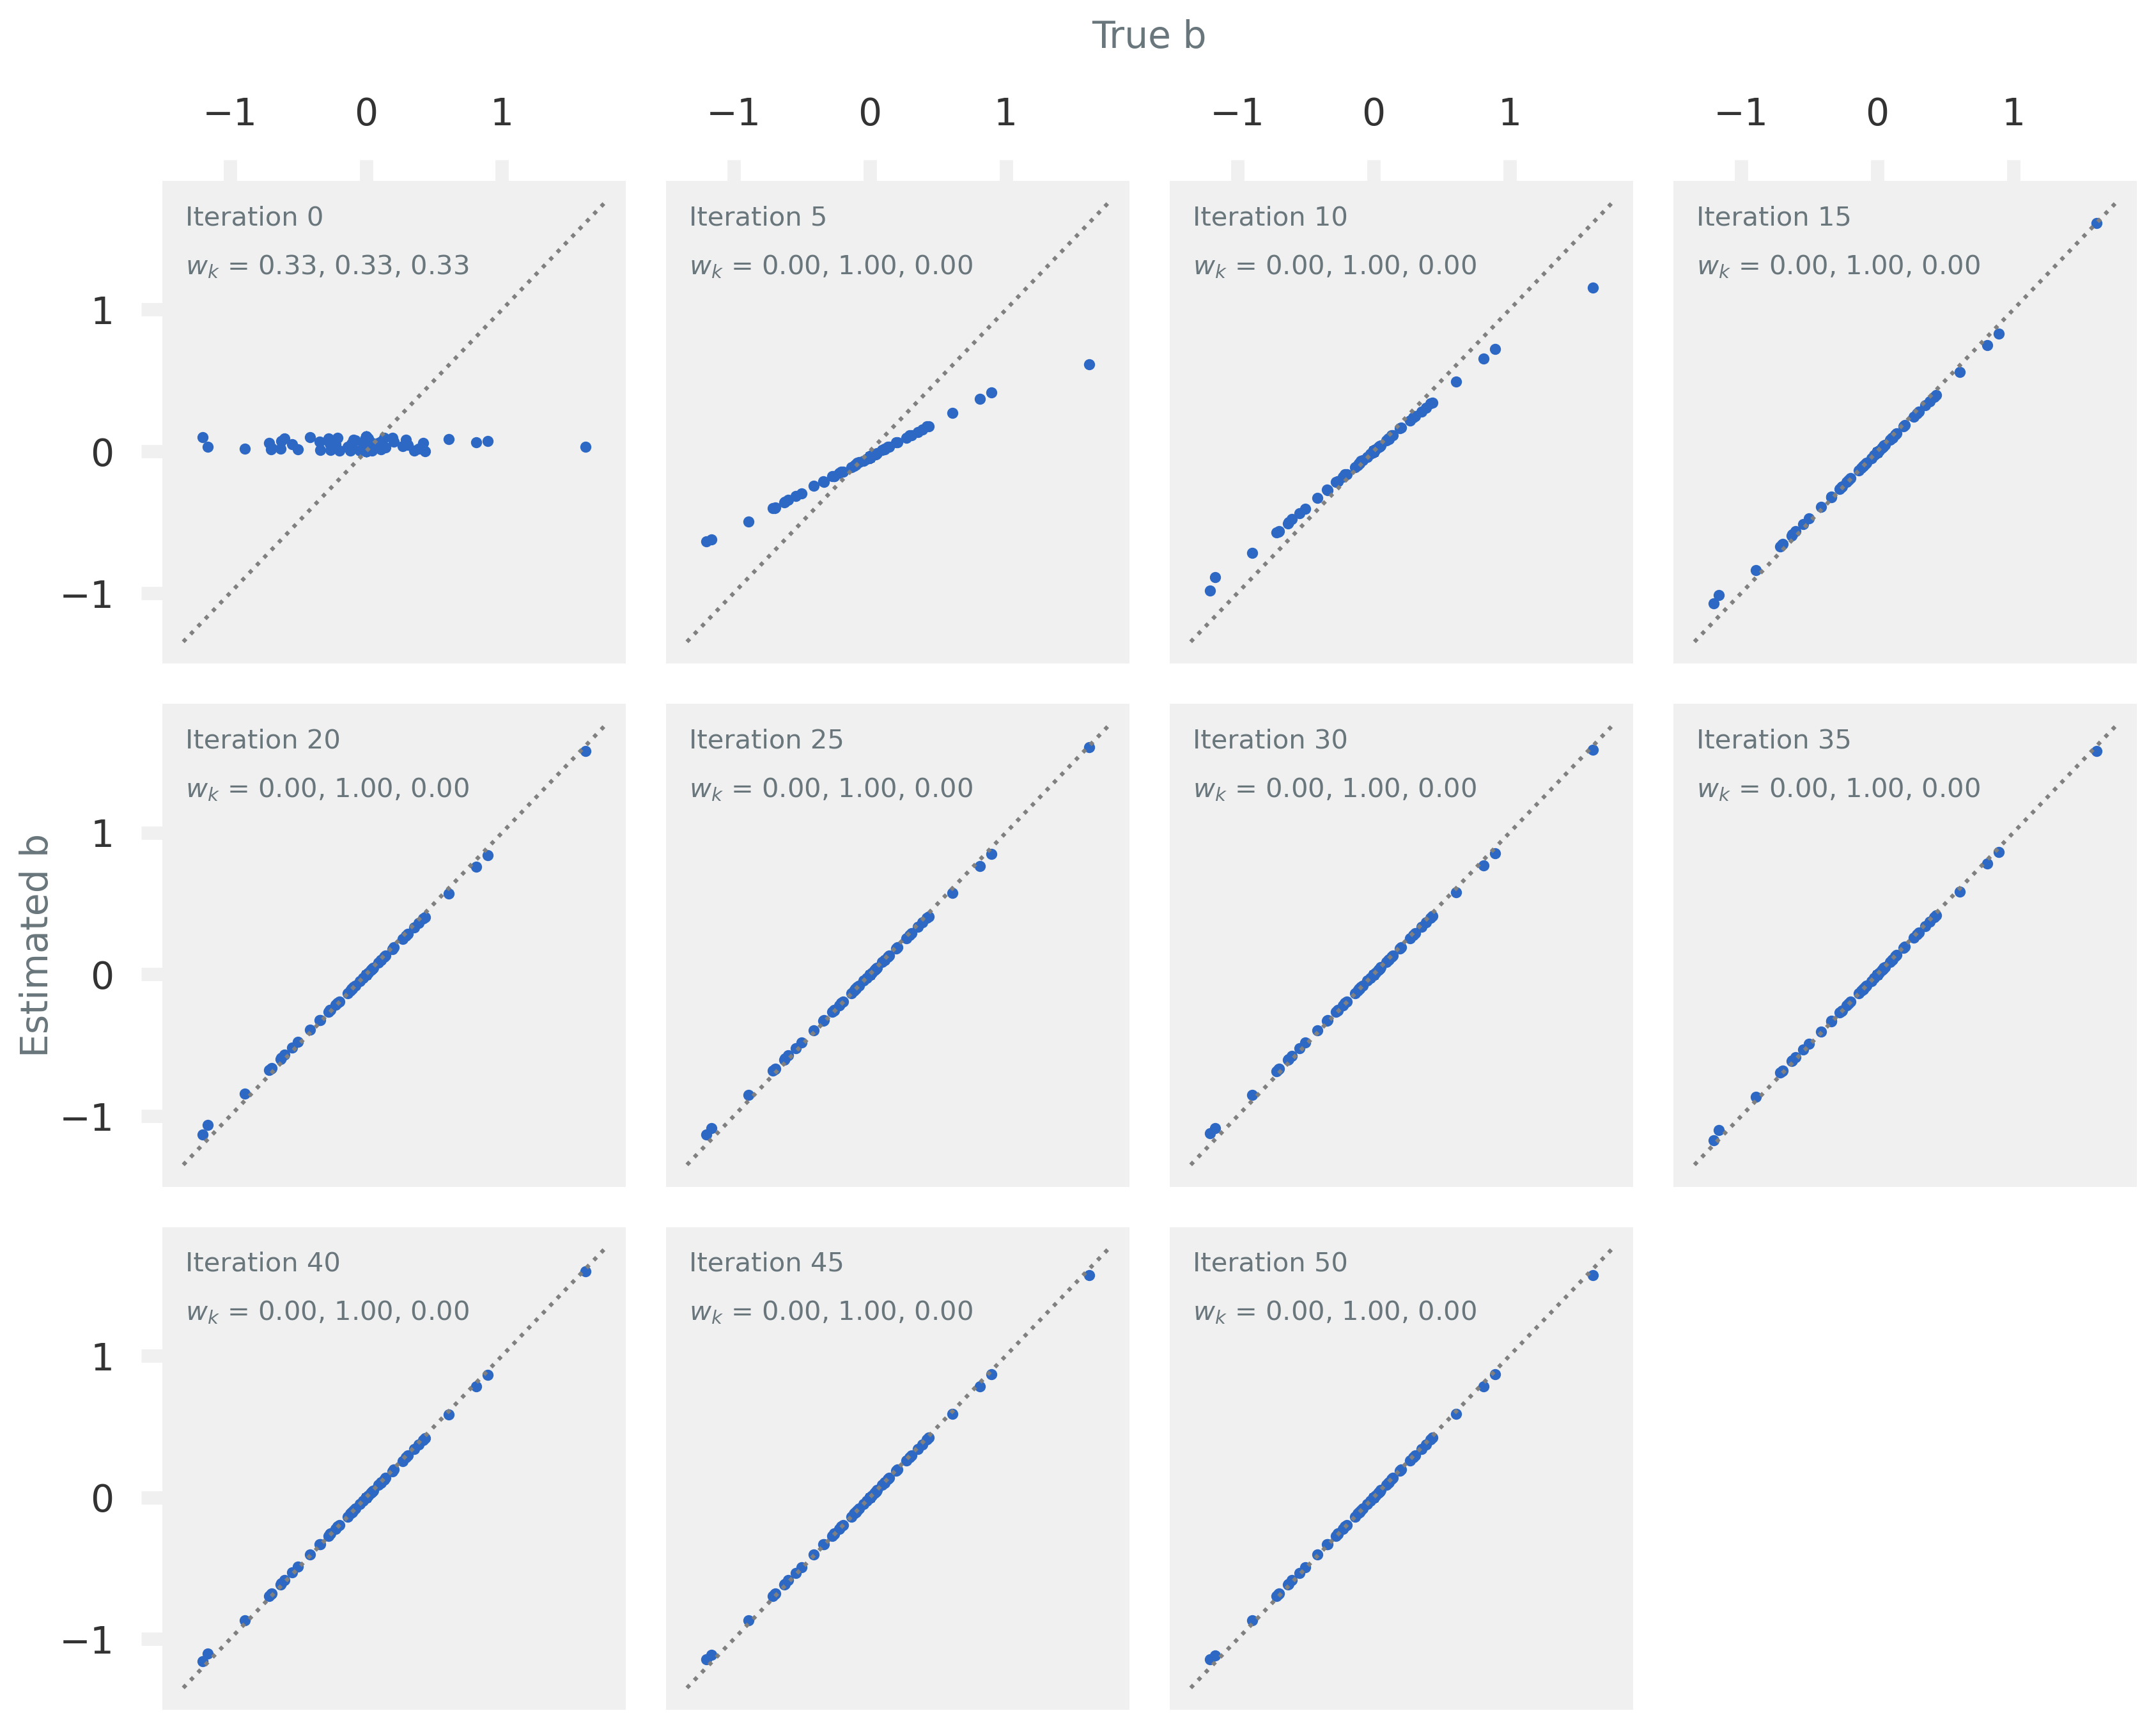

In [8]:
#collapse-hide

subplot_h = 1.8
nstep = 5
nplot = int(niter / nstep) + 1
ncol  = 4
nrow  = int(nplot / ncol + 1) if nplot%ncol != 0 else int(nplot / ncol)
figw  = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh  = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
figscale = 12.0 / figw

bgcolor = '#F0F0F0'
highlight_color = '#EE6868'
subdue_color = '#848f94'
text_color = '#69767c'

fig = plt.figure(figsize = (figw * figscale, figh * figscale))
axmain = fig.add_subplot(111)

for i in range(nplot):
    ax  = fig.add_subplot(nrow, ncol, i + 1)
    itr = i * nstep
    
    params = cg_min.allvecs[itr]
    z_it = params[:p]
    a_it = params[2*p:]
    #lj_it = params[p:2*p]
    w_it = softmax(a_it, base = softmax_base)
    b_it = shrink_theta(z_it, strue, w_it, sk, dj)
    
    ax.scatter(btrue, b_it, s=10)
    mpl_utils.plot_diag(ax)
    
    wtext = r'$w_k$ = ' + ', '.join([f"{w:.2f}" for w in w_it])
    itrtext = f"Iteration {itr}"
    
    ax.text(0.05, 0.85, wtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.text(0.05, 0.95, itrtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    
    ax.set_facecolor(bgcolor)
    for side, border in ax.spines.items():
        border.set_visible(False)
    if i < ncol:
        ax.tick_params(top = True, labeltop = True, color = bgcolor, width = 5)
        #ax.set_xticks(np.log10([0.001, 0.01, 0.1, 1.0]))
    if i%ncol == 0:
        ax.tick_params(left = True, labelleft = True, color = bgcolor, width = 5)
    #ax.set_ylim(-0.1, 2.1)
    
axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.set_ylabel(r'Estimated b', labelpad = 40, color = text_color)
axmain.set_xlabel(r'True b', labelpad = 50, color = text_color)
axmain.xaxis.set_label_position('top') 


plt.tight_layout()
# plt.savefig(f'../plots/{fileprefix}.pdf', bbox_inches='tight')
# plt.savefig(f'../plots/{fileprefix}.png', bbox_inches='tight')
plt.show()